In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style()
import wave
from scipy import signal
from scipy.io import wavfile
from scipy.fftpack import fft, ifft

In [2]:
path = '../exp/data'
dis = [20, 40, 80, 100]
db = [-1, 15, 30, 40]
repeat = list(range(5))

In [58]:
def load_wav(name):
    '''
    with wave.open(name, 'rb') as f:
        fs = f.getframerate()
        nframes = f.getnframes()
        str_data = f.readframes(nframes)
        nchannels = f.getnchannels()
        print(len(str_data))
        
    wave_data = np.frombuffer(str_data, dtype=np.int16)
    print(wave_data.shape)
    if nchannels == 2:
        wave_data = wave_data.reshape(2, -1)
        wave_data = wave_data.mean(axis=0)
    return fs, wave_data
    '''
    fs, sig = wavfile.read(name)
    if len(sig.shape) > 1:
        sig = sig.mean(axis=1)
    return fs, sig

def load_all(path, dis, db, repeat):
    for di in dis:
        for d in db:
            for r in repeat:
                name = r'{path}/{dis}cm_{db}db_{repeat}.wav'.format(**{
                    'path': path,
                    'dis': di,
                    'db': d,
                    'repeat': r
                })
                load_wav(name)

[ 0.   0.   0.  ...  7.   0.5 -6.5]
(153600,)


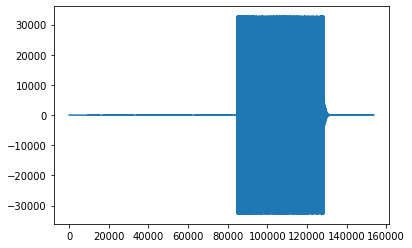

In [709]:
#load_all(path, dis, db, repeat)
fs, data = load_wav('../wybbb.wav')
print(data[:])
plt.plot(data)
print(data.shape)

In [809]:
def fda(x, floor, ceil, fs):
    b, a = signal.butter(8, [2 * floor / fs, 2 * ceil / fs], 'bandpass')
    data = signal.filtfilt(b, a, x)
    return data

48000
(153600,)


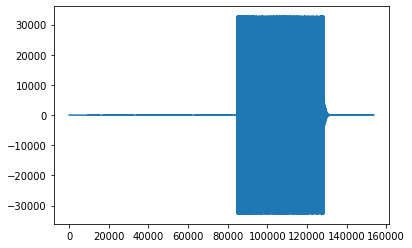

In [711]:
filted = fda(data[:], 17500, 18500, fs)
plt.plot(data)
#plt.plot(filted[:1000])

In [796]:
def dfft(data, f, fs):
    n = data.shape[0]
    window = 100
    impulse_fft = np.zeros((n, 1))
    for i in range(n - window):
        y = fft(data[i:i + window])
        y = np.abs(y)
        index_impulse = round(f / fs * window)
        impulse_fft[i] = np.max(y[index_impulse - 2:index_impulse + 3])
    return impulse_fft

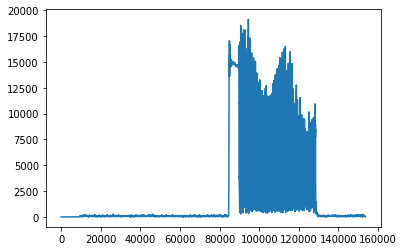

In [797]:
impulse = dfft(filted, 18000, fs)
plt.plot(impulse[:])

In [798]:
def smooth(a, window):
    a = a.squeeze()
    out = np.convolve(a, np.ones(window, dtype=int),'valid') / window
    r = np.arange(1, window - 1, 2)
    start = np.cumsum(a[:window - 1])[::2] / r
    stop = (np.cumsum(a[:-window:-1])[::2] / r)[::-1]
    return np.concatenate((start, out, stop))

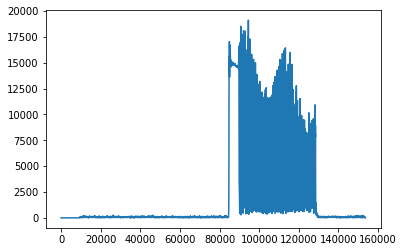

In [799]:
sm_data = smooth(impulse, 5)
#sm_data = smooth(data, 5)
plt.plot(sm_data[:])

In [803]:
def find_max(data, half_window, thres=0.4):
    data = data / np.max(data)
    n = data.shape[0]
    position_impulse = []
    for i in range(half_window, n - half_window):
        if data[i] > thres and data[i] == np.max(data[i - half_window:i + half_window + 1]):
            position_impulse.append(i)
    return position_impulse

In [792]:
impulse_pos = find_max(sm_data, 100)

print(impulse_pos)

[84949, 85253, 85457, 85761, 86265, 86765, 86965, 87661, 87861, 88061, 88261, 88965, 89165, 89661, 89772, 90460, 90707, 91264, 91503, 91753, 92160, 92564, 92967, 93206, 93617, 94318, 94560, 95263, 95671, 96217, 96767, 97167, 97571, 98117, 98813, 99367, 99766, 100313, 100713, 101413, 101813, 102359, 102913, 103155, 103558, 104258, 104658, 105054, 105454, 105996, 106242, 106653, 106888, 107422, 107688, 107938, 108345, 108745, 109141, 109537, 109937, 110460, 111183, 111706, 112133, 112652, 113198, 113644, 114047, 114747, 115147, 115639, 116097, 116585, 117046, 117446, 117846, 118546, 118796, 119346, 119742, 120445, 120692, 121412, 121795, 122362, 122831, 123295, 123695, 124395, 124796, 125045, 125449, 126145, 126712, 127345, 127891, 128141, 128395]


In [811]:
def demod(pos, d=150, eps=60):
    N = len(pos)
    eps = 60
    message_2 = [0] * ((N - 1) * 2)
    for i in range(N - 1):
        delta = pos[i + 1] - pos[i] - 100
        for mul in range(4):
            if abs(delta - d * (mul + 1)) < eps:
                message_2[i * 2], message_2[i * 2 + 1] = mul >> 1, mul & 1;
                break;
        if delta - d * 4 > eps:
            message_2[i * 2], message_2[i * 2 + 1] = 1, 1
    return message_2

In [794]:
arr = demod(impulse_pos)
print(arr)
print(len(arr))

[0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0]
196


In [795]:
def decode(arr):
    bin_res = ''.join(map(str, arr))
    res = ''.join([chr(int(bin_res[8*i:8*i+8], 2)) for i in range(len(bin_res) // 8)])
    return res
res = decode(arr)
print(res)

QÍ¥¹¡ÕU¹¥ÙÉÍÑâ


In [63]:
real='0101010001110011011010010110111001100111011010000111010101100001001000000101010101101110011010010111011001100101011100100111001101101001011101000111100100100000'
real

'0101010001110011011010010110111001100111011010000111010101100001001000000101010101101110011010010111011001100101011100100111001101101001011101000111100100100000'

In [ ]:
pulse_1.wav, 0.09, 100
pau_pul_1.wav, 0.1, 100
50_150.wav, 0.3, 150
wybb.wav, 0.36, 150

In [119]:
import os

In [125]:
os.listdir('../exp')

['20191117_160148.m4a',
 '20191117_160152.m4a',
 '20191117_160157.m4a',
 '20191117_160202.m4a',
 '20191117_160206.m4a',
 '20191117_160229.m4a',
 '20191117_160247.m4a',
 '20191117_160251.m4a',
 '20191117_160256.m4a',
 '20191117_160300.m4a',
 '20191117_160324.m4a',
 '20191117_160329.m4a',
 '20191117_160333.m4a',
 '20191117_160338.m4a',
 '20191117_160342.m4a',
 '20191117_160440.m4a',
 '20191117_160445.m4a',
 '20191117_160449.m4a',
 '20191117_160518.m4a',
 '20191117_160547.m4a',
 '20191117_160621.m4a',
 '20191117_160625.m4a',
 '20191117_160630.m4a',
 '20191117_160634.m4a',
 '20191117_160639.m4a',
 '20191117_161205.m4a',
 '20191117_161251.m4a',
 '20191117_161256.m4a',
 '20191117_161300.m4a',
 '20191117_161305.m4a',
 '20191117_161330.m4a',
 '20191117_161335.m4a',
 '20191117_161339.m4a',
 '20191117_161343.m4a',
 '20191117_161348.m4a',
 '20191117_161402.m4a',
 '20191117_161407.m4a',
 '20191117_161411.m4a',
 '20191117_161432.m4a',
 '20191117_161436.m4a',
 '20191117_161452.m4a',
 '20191117_16150

In [818]:
def decode_wave(name, delta, thres, eps):
    fs, data = load_wav(name)
    filted = fda(data, 17500, 18500, fs)
    impulse = dfft(filted, 18000, fs)
    sm_data = smooth(impulse, 5)
    impulse_pos = find_max(sm_data, 100, thres)
    arr = demod(impulse_pos, delta, eps)
    res = decode(arr)
    return res, ''.join(map(str, arr))

In [819]:
decode_wave('../wybb.wav', 150, 0.36, 60)

('ß Tsinghua University ',
 '11011111001000000101010001110011011010010110111001100111011010000111010101100001001000000101010101101110011010010111011001100101011100100111001101101001011101000111100100100000')

In [832]:
def auto_search(name, delta, eps, start, end):
    interval = 0.02
    thres = start
    while thres < end:
        res, arr = decode_wave(name, delta, thres, eps)
        print('{:.2f} {} {}'.format(thres, res, arr))
        thres += interval

In [824]:
auto_search('../wybbb.wav', 150, 60, 0.25, 0.45)

0.25   1QÍ¥¹¡ÕU¹¥ÙÉÍ¥Ñä 00000000000000000011000100010000000011001000000101010001110011011010010110111001100111011010000111010101100001001000000101010101101110011010010111011001100101011100100111001101101001011101000111100100100000
0.26   1QÍ¥¹¡ÕU¹¥ÙÉÍ¥Ñä 00000000000000000011000100010000000011001000000101010001110011011010010110111001100111011010000111010101100001001000000101010101101110011010010111011001100101011100100111001101101001011101000111100100100000
0.27   1QÍ¥¹¡ÕU¹¥ÙÉÍ¥Ñä 00000000000000000011000100010000000011001000000101010001110011011010010110111001100111011010000111010101100001001000000101010101101110011010010111011001100101011100100111001101101001011101000111100100100000
0.28   1QÍ¥¹¡ÕU¹¥ÙÉÍ¥Ñä 00000000000000000011000100010000000011001000000101010001110011011010010110111001100111011010000111010101100001001000000101010101101110011010010111011001100101011100100111001101101001011101000111100100100000


KeyboardInterrupt: 

In [826]:
import os

In [833]:
files = os.listdir('../exp')
for index, name in enumerate(files):
    filename = '../exp/' + name
    if index < 30:
        delta, eps = 100, 45
    else:
        delta, eps = 150, 60
    print(index)
    auto_search(filename, delta, eps, 0.25, 0.45)

0
0.25 ÊW!2G6ævVVâbG'6G 1100101001010111001000010011001000000101010001110011011010010110111001100111011010000111010101100001001000000101010101101110001010010111011000100100011100100111001101101001011101000111100100100000
0.27 ÊW!2G6ævVVâbG'6G 1100101001010111001000010011001000000101010001110011011010010110111001100111011010000111010101100001001000000101010101101110001010010111011000100100011100100111001101101001011101000111100100100000
0.29 ÊW!2G6ævVVâbG'6G 1100101001010111001000010011001000000101010001110011011010010110111001100111011010000111010101100001001000000101010101101110001010010111011000100100011100100111001101101001011101000111100100100000
0.31 ÊW!2G6ævVVâbG'6G 1100101001010111001000010011001000000101010001110011011010010110111001100111011010000111010101100001001000000101010101101110001010010111011000100100011100100111001101101001011101000111100100100000
0.33 ÊW!2G6ævVÈ[]Ú]H 110010100101011100100001001100100000010101000111001101101001

0.25 $ð¤ÈÖ[ÚK]YòrG 0010010000000101111100001010010011001000000101010000110011010110010110111000100111011010000111010101100000001000000100010100101110011001010111010101100111110010011100100100011100011101000111100000010000
0.27 $ð¤ÈÖ[ÚK]YÉÉtx 00100100000001011111000010100100110010000001010100001100110101100101101110001001110110100001110101011000000010000001000101001011100110010101110101011001110010011100100100011100011101000111100000010000
0.29 $ð¤ÈÖ[ÚK]YÉÉtx 00100100000001011111000010100100110010000001010100001100110101100101101110001001110110100001110101011000000010000001000101001011100110010101110101011001110010011100100100011100011101000111100000010000
0.31 $ð¤ÈÖ[ÚK]YÉÉ±Ñà 001001000000010111110000101001001100100000010101000011001101011001011011100010011101101000011101010110000000100000010001010010111001100101011101010110011100100111001001101100011101000111100000010000
0.33 $ð¤ÈÖ[ÚK]Ü½Ñà 001001000000010111110000101001001100100000010101000011

0.41 qIQÌ±¹iÍX¡% µge a3Öµ! 01110001010010010000010000011111010100010001110011001100101100011011100101101001110011010101100010100001001001010000000010110101011001110110010100000000011000010011001111010110100000001011010100100001
0.43 qIQó?ZsV(I@5ÏZÒ 01110001010010010000010000011111010100011111001100111111000111100101101001110011010101100010100001001001010000000011010110011101100101000000000110000100110011110101101000000010110100100001
8
0.25 × AÄÈÚ[YÖTHU[]\ÖV 110101110010000001000001110001001100100000000101000111001101101001011011010110011101011000011101010101000100100001010101010110111001101001011101100110010101110010011100110101100001011001010110100000010000
0.27 × AÄÈÚ[YÖTHU[]\ÖV 1101011100100000010000011100010011001000000001010001110011011010010110110101100111010110000111010101010001001000010101010101101110011010010111011001100101011100100111001101011000010110010101101000001100
0.29 × AÄÈÚ[YÖTHU[]\ÖV 11010111001000000100000111000100110010000000010

0.33 ) HÄ!HÔÛÅXà[ÐE\ÁG 001010010001000000000000010010001100010000100001000101000100100011010100110110110000010111000101100111010101100011100000000001010101101100010110000000011101000001000101010111001001110011000001100001110100011110000010000011
0.35 ) HÌQ#SluclXUÉÌtx  00101001000100000000000001001000110011001000010001010001001000110101001101101100000101110001011001110101011000111000000000010101011011000101100000000111000001000101010111001001110011000001100001110100011110000010000011
0.37 ) HÌQ#SlÕ U¶Árs 00101001000100000000000001001000110011001000010001010001001000110101001101101100000101110001110111010101100011100000000001010101101101100000000111000001000101010111001001110011000001100001110100011110000010000011
0.39 ) HÌQ#M°\wV8VØÅ\ÁG¸ 001010010001000000000000010010001100110010000100010100010010001101001101101100000101110001110111010101100011100000000001010101101101100000000111110001010101110010011100110000011000011101000111101110000011
0.41 ) HÌQ#

0.33 ÎQK¨ÊM3UâÇVW'6G 11001110000010111000111000000100010100010001110110011001010010111010100011001010000111010100110100110011010101011110001011000111010101100101011100100111001101101001011101000111100100100000
0.35 Î?K¨Ìu75^,uersity  11001110001111111000000100011101000111011001100101001011101010001100110001110101001101110011010101011110001011000111010101100101011100100111001101101001011101000111100100100000
0.37 ÎðGGfRê<u<Õx±ÕÉÍ¥Ñä 1100111011110000010001110100011101100110010100101110101000111100011101010011110011010101011110001011000111010101100101011100100111001101101001011101000111100100100000
0.39 ÏÄtvgºO5xÇVW'6G 110011111100010001110100011101100110011110111010100011110001110101001111001101010111100011000111010101100101011100100111001101101001011101000111100100100000
0.41 ÏGçºtóÜõersity  1100111100010011010001111110011110111010100011000111010011110011110111001111010101100101011100100111001101101001011101000111100100100000
0.43 Ï7ùû1ÓýÏVW'6G 110011110011011111111

0.27 ÐtÜÛÇ<ÛngýüEm¥Ùç6G 1101000001110100110111001101101111000111001111001101101101101110011001111111110111111100010001010110110110100101110110011001010111100111001101101001011101000111100100100000
0.29 ÐtÜÛÇ<Ûngýý6é}ç6G 11010000011101001101110011011011110001110011110011011011011011100110011111111101111111010011011011101001011111011001010111100111001101101001011101000111100100100000
0.31 ÐtÜÛÇ<ý¹÷ónßgç6G 110100000111010011011100110110111100011100111100111111011011100110011111111101111111001101101110110111110110011111100111001101101001011101000111100100100000
0.33 ÐtÜÛÏÛçÿónÝómÑä 11010000011101001101110011011011110011111101101111100111111111111111001101101110110111011001111111110011011011011101000111100100100000
0.35 ÐtÜÛÿoÿþÝÍ·GH 11010000011101001101110011011011111111110110111101111111111111111111111011011101100111111100110110110111010001110100100000
0.37 ÐtÜÛÿ½ÿÿ·gómÑÒ 1101000001110100110111001101101111111111101111011111111111111111101101110110011111110011011011011101000111

0.35 ÓÀsV#ÿ 11010011110000000111001100001111010101100010001111111111011111111111
0.37 ÓÀslÿ 1101001111000000011100110000111101101100111111110111111111
0.39 ÓÀsÿ 1101001111000000011100110000111111111111111111
0.41 ÓÀsÿ 1101001111000000011100110000111111111111111111
0.43 ÓÀsÿ 11010011110000000111001100001111111111111111
24
0.25 QFAPÌ¥¸aÔU¹¥ÙUÉ¥À9 000111000101000101000110000100000001010100010000100010010000000100001100000011000100000101010000110011001010010110111000100011100110000111010100100001001000000101010101101110011010010111011001010101011100100110001100101001011100000000111001000100
0.27 QFAPÌ¥¸aÔU¹¥ÙUÉ¥À9 000111000101000101000110000100000001010100010000100010010000000100001100000011000100000101010000110011001010010110111000100011100110000111010100100001001000000101010101101110011010010111011001010101011100100110001100101001011100000000111001000100
0.29 QFAPÌ¥¸aÔU¹¥ÙUÉ¥À9 00011100010100010100011000010000000101010001000010001001000000010000

0.31  $@PV q@¥­ a`ZÕ"vtH 000000000010010010000100100010110100000001010000000001100101011000000000011100010000001001000000100110011010010110101101100111001001010110100000011000010110000000011000000010110101101000000010100100001101010110011000001000100111011001110100000000110100100000
0.33  $@PV q@¥­ a`ZÕ"vtH 000000000010010010000100100010110100000001010000000001100101011000000000011100010000001001000000100110011010010110101101100111001001010110100000011000010110000000011000000010110101101000000010100100001101010110011000001000100111011001110100000000110100100000
0.35  $Á@XÄ	f¶rV`-h
  0000000000100100100001001000101111000001010000000001100101011000000000011100010000001001000000100110011010010110101101100111001001010110100000011000010110000000011000000010110101101000000010100100001101010110011000001000100111011001110100000000110100100000
Y'g@4 000000000010010010000100100010111100010100000000011001010110000000000111000100000010010000001001100110100101101

0.33 !
 òG6ævV[]\Ú]H 00100001000010100000000011110010000001010100011100110110100101101110011001110110100001110101011000011100000101010101101110011010010111011001100101011100100111001101101001011101000111100100100000
0.35 ,  TsinghuaÁU¹¥ÙÉÍ¥Ñä 0010110010100000000011110010000001010100011100110110100101101110011001110110100001110101011000011100000101010101101110011010010111011001100101011100100111001101101001011101000111100100100000
0.37 2<QÍ¥¹¡Õ[]\Ú]H 001100101000000000111100100000010101000111001101101001011011100110011101101000011101010110001100000101010101101110011010010111011001100101011100100111001101101001011101000111100100100000
0.39 2<QÍ¥¹¡øÁU¹¥ÙÉÍ¥Ñä 00110010100000000011110010000001010100011100110110100101101110011001110110100001111110001100000101010101101110011010010111011001100101011100100111001101101001011101000111100100100000
0.41 8ÈÚ[Ú>0University  0011100000000011110010000001010100011100110110100101101110011001110110100011111000110000010101010110

0.29  õ=ÖíøÕU¹¥çÿity  0000000000001111000101111111010100111101110101101110110111111000110101011000010010000001010101011011100110100101111001111111111101101001011101000111100100100000
0.31  SÝ{~5a Uni{ÿity  00000000000011110001011101010011110111010111101101111110001101010110000100100000010101010110111001101001011110111111111101101001011101000111100100100000
0.33  uïãV5[^ÿitä 0000000000001111000101110111111101110101111011111110001101010110000100100011010101011011100110100101111011111111011010010111010011100100100000
0.35  _ýÿXHÕnkïÚ4ä 000000000000111101011111111111011111111110001101010110000100100011010101011011100110101111101111110110100011010011100100100000
0.37 õÿßøÕ[ûöä 0000110011110101111111111101111111111000110101011000010010001101010110111001101011111011111101101000111011100100100000
0.39 ßøÕ[ÿøîH 0000111101111111110111111111100011010101100001001000110101011011100110101111111111111000111011100100100000
ÿXÍ[ÿøîH 000011011111111110001101010110001100110101011

0.31 ÃC Tsinghua1U	¤Ù'6´y  000001000000000111000011010000110010000001010100011100110110100101101110011001110110100001110101011000010011000101010101000010011010010011011001100101110010011100110110101101000111100100100000
0.33 ÃC Tsinghua1Uæf\ÚÑä 0000010000000001110000110100001100100000010101000111001101101001011011100110011101101000011101010110000100110001010101011110011010010011011001100101110010011100110110101101000111100100100000
0.35 ÃC Tsinghua1Uæf\ëG 00000100000000011100001101000011001000000101010001110011011010010110111001100111011010000111010101100001001100010101010111100110100100110110011001011100100111001110101101000111100100100000
0.37 ÃC Tsinghua1Uæf\ëH 000001000000000111000011010000110010000001010100011100110110100101101110011001110110100001110101011000010011000101010101111001101001001101100110010111001001110011101011000111100100100000
0.39 ÃC Tsinghua1Uæf\ëp 0000010000000001110000110100001100100000010101000111001101101001011011100110011101101000011101

0.27 TÚ[ÒXH[\Ú]H 0101010000001100000001000000000000001000000101010001110011011010010110111001000011010010000111010101100001001000000101010101101110011000000111011001100101011100100111001101101001011101000111100100100000
0.29 T TsinCHua Un`versity  01010100000011000000010000000011001000000101010001110011011010010110111001000011010010000111010101100001001000000101010101101110011000000111011001100101011100100111001101101001011101000111100100100000
0.31 T TsinCHua Un`versity  01010100000011000000010000000011001000000101010001110011011010010110111001000011010010000111010101100001001000000101010101101110011000000111011001100101011100100111001101101001011101000111100100100000
0.33 T TsinCHua Un`versity  01010100000011000000010000000011001000000101010001110011011010010110111001000011010010000111010101100001001000000101010101101110011000000111011001100101011100100111001101101001011101000111100100100000
0.35 T TsinCHua Un`versity  01010100000011000000010000000011001000000

0.41 Ë@ ÞLÈÚ[È[]\Úx 11001011010000000000000011011110010011000000110011001000000101010001110011011010010110111100100000010101010110111001101001011101100110010101110010011100110110100111100000
0.43 Ë@ ÞLÈÚ[È[]\Û 11001011010000000000000011011110010011000000110011001000000101010001110011011010010110111100100000010101010110111001101001011101100110010101110010011100110110111100
46
0.25 À@ ` @ QÍ¥¹¡ÕU¹¥Ù'6G 11000000010000000000000001100000000000000100000000000100000000000000110010000001010100011100110110100101101110011001110110100001110101011000010010000001010101011011100110100101110110011001111100100111001101101001011101000111100100100000
0.27 À@ ` @ QÍ¥¹¡ÕU¹¥ÙöG 110000000100000000000000011000000000000001000000000001000000000000001100100000010101000111001101101001011011100110011101101000011101010110000100100000010101010110111001101001011101100110011111111101101001011101000111100100100000
0.29 À@ ` @ QÍ¥¹¡ÕU¹¥Ùÿity  110000000100000000000000011000000000000

0.29 Ø @  dÈÚ[ÛÕþiversity  100011001101100000000000010000000000000000000100000000000110010011001000000101010001110011011010010110111001100111011011110101011000011111111110011010010111011001100101011100100111001101101001011101000111100100100000
0.31 Ø @  dÈÚ[ÛÖ?éversity  1000110011011000000000000100000000000000000001000000000001100100110010000001010100011100110110100101101110011001110110111101011000111111111010010111011001100101011100100111001101101001011101000111100100100000
0.33 Ø @  dðTsingoXÿ¥ÙÉÍ¥Ñç 100011001101100000000000010000000000000000000100000000000110010011110000010101000111001101101001011011100110011101101111010110001111111110100101110110011001010111001001110011011010010111010001111001110000
0.35 Ø @  dðTsingo[þfW'6G 1000110011011000000000000100000000000000000001000000000001100100111100000101010001110011011010010110111001100111011011110101101111111110100101110110011001010111001001110011011010010111010001111001110000
0.37 Ø @ OG6æwÖþfW'6G 1000110011

0.35 8 Ë Ts!L7@ua h*L&vÓ 001110000000000000010011110010110010000001010100011100110010000101001100001101110100000001110101011000010010000000010101011010000010101001001100000101000001100000100110011101101101001100000111100101100000
0.37 8 ²G2ÃtVV¤ÁAgm0y` 00111000000000000001001110110010000001010100011100110010000101001100001101110100000001110101011000010010000000010101011010000010101001001100000101000001100000100110011101101101001100000111100101100000
ÐXHZ ÎÈÈS
	´Áå 001110000000000011001110110010000001010100011100110010000101001100001101110100000001110101011000010010000000010101011010000010101001001100000101000001100000100110011101101101001100000111100101100000
0.41 8 Ï TÌ0ÝÕU ©0P`ÛLX 00111000000000001100111100100000010101001100110010000101001100001101110100000001110101011000010010000000010101011010000010101001001100000101000001100000100110011101101101001100000111100101100000
0.43 8<S2ÃtV5Z
	´Áå 00111000000001110011110010000001010100110011001000010100

0.35 ñ    2Âinghu`U¹¥ÙÁsitä 1111000100010000000100001000010000000000000000000000000000000000001100100000010000010001110000100110100101101110011001110110100001110101011000001000000101010101101110011010010111011001100101011100000101110011011010010111010011100100100000
0.37 ñ    2ÂinghÕVæfWÍ¥ÞH 111100010001000000010000100001000000000000000000000000000000000000110010000001000001000111000010011010010110111001100111011010001101010110000010000001010101011011100110100101110110011001010111000001011100110110100101110111100100100000
[]\6y 111100010001000000010000100001000000000000000000000000000000000000110010000001010100110011011010010110111001100111011010001101010110001100001101010110111001101001011101100110010101110000010111001101101001011101111001110000
3inghÕ5niversiw 1111000100010000000100001000010000000000000000000000000000000000001100100000110100110011011010010110111001100111011010001101010110001100001101010110111001101001011101100110010101110010011100110110100101110

\Ú]H 100101110000000100001000111000010100000000000000000000010000110000100000001001000100110011011010010110111001100111011010000111010101100001001000000101010101101110001000000011011000000001011100100111001101101001011101000111100100100000
60
0.25 Ä@C1QÍ§ÚXH[]\Ú]H 110001000100000001000011001100010101000111001101101001111001100111011010000111010101100001001000000101010101101110011010010111011001100101011100100111001101101001011101000111100100100000
0.27 ÑôsiævVVæfW'6G 110100010000000100001100111101000111001101101001111001100111011010000111010101100001001000000101010101101110011010010111011001100101011100100111001101101001011101000111100100100000
0.29 Ä3ÑÍ§ÚXH[]\Ú]H 1100010000000100001100111101000111001101101001111001100111011010000111010101100001001000000101010101101110011010010111011001100101011100100111001101101001011101000111100100100000
0.31 Ä3ç6ghua University  1100010000000100001100111110011100110110100111100110011101101000011101010110000100100000010101

0.25 3 T TsInGhua Universit 0011001100000000010101000000001100100000010101000111001101001001011011100100011101101000011101010110000100100000010101010110111001101001011101100110010101110010011100110110100101110100010010000000100000
0.27 3 T TsInGhua UniversitI  00110011000000000101010000000011001000000101010001110011010010010110111001000111011010000111010101100001001000000101010101101110011010010111011001100101011100100111001101101001011101000100100100100000
0.29 3 T TsInGhua UniversitI  00110011000000000101010000000011001000000101010001110011010010010110111001000111011010000111010101100001001000000101010101101110011010010111011001100101011100100111001101101001011101000100100100100000
0.31 3 T TsInGhua UniversitI  00110011000000000101010000000011001000000101010001110011010010010110111001000111011010000111010101100001001000000101010101101110011010010111011001100101011100100111001101101001011101000100100100100000
0.33 3 T TsInGhua UniversitI  00110011000000000101010000000011001000000

0.37 À@@ 0æ  4 T]W'4×G¸ 110000001000010001000000010000001000100000000001000000000011000010010001100101101110011010100000101000000011010000010001000000001000000101010100000001111001101001011101100100010101011100100111001101001101011101000111101110000000
0.39 À@@@ÂF[T@ UæfW'7]à 11000000100001000100000001000000100010000000000101000000110000100100011001011011100110101001101000000011010101000100000000100000010101010000000111100110100101110110011001010111001001110011011101011101000111101110000000
0.41 À@@G	njh5BægrsuÑî 11000000100001000100000001000000100010000000000101000111000010010001100101101110011010100110100000110101010001010000100000010101010000101110011010010111011001110111001001110011011101011101000111101110000000
0.43 À@@G	¥æ¦TÂP¹¥ßrsuÑî 110000001000010001000000010000001000100000000001010001110000100110100101111001101010011010000011010101001100001000000101010100001011100110100101110111110111001001110011011101011101000111101110000000
68
0.25   TsABc@a 

0.29 |  P#h.ha Univerphty  01111100000000000000000000000011010100000001000000100011011010000010111000000111011010000000010101100001001000000101010101101110011010010111011001100101011100100111000001101000011101000111100100100000
0.31 |  P#h.ha Univerphty  01111100000000000000000000000011010100000001000000100011011010000010111000000111011010000000010101100001001000000101010101101110011010010111011001100101011100100111000001101000011101000111100100100000
0.33 |  P#h.ha Univerphty  01111100000000000000000000000011010100000001000000100011011010000010111000000111011010000000010101100001001000000101010101101110011010010111011001100101011100100111000001101000011101000111100100100000
0.35 |  P#h.ha Univerphty  01111100000000000000000000000011010100000001000000100011011010000010111000000111011010000000010101100001001000000101010101101110011010010111011001100101011100100111000001101000011101000111100100100000
0.37 |  P#h.ha Univerphty  01111100000000000000000000000011010100000

Oinghul[]\Ú]H 00000100010000000000000000000000000000110000110101001111011010010110111001100111011010000111010101101100000101010101101110011010010111011001100101011100100111001101101001011101000100100100100000
}¥¾xöÁU¹¥æWitI  00000100010000000000000000000000000000110000110101111101101001011011111001111000111101101100000101010101101110011010010111100110010101111001111101101001011101000100100100100000


In [ ]:
2 0.37
3 0.41
15 0.35 0.41
16 0.29 0.31 *
16 0.33 0.35
17 0.25-0.43
21 0.29 0.31
25 0.25 0.27 0.31 0.41 0.43
26 0.35 0.39
30 0.25 0.27 0.29 *
30 0.35 0.41 0.43
35 0.25 0.27
36 0.25-0.31 *
38 0.25-0.41
40 0.25 0.27
41 0.33-0.37 *
42 0.29-0.35 *
43 0.37
44 0.39-0.41
45 0.27 0.31 0.37
49 0.25
50 0.29-0.35
53 0.35
56 0.25-0.33
57 0.41 0.43
60 0.31
61 0.39-0.41
64 0.25-0.39 *
66 0.33
68 0.25-0.43
70 0.27
71 0.29-0.43
73 0.41 0.43
